CREDIT: https://pythonprogramming.net/custom-environment-reinforcement-learning-stable-baselines-3-tutorial/?completed=/saving-and-loading-reinforcement-learning-stable-baselines-3-tutorial/

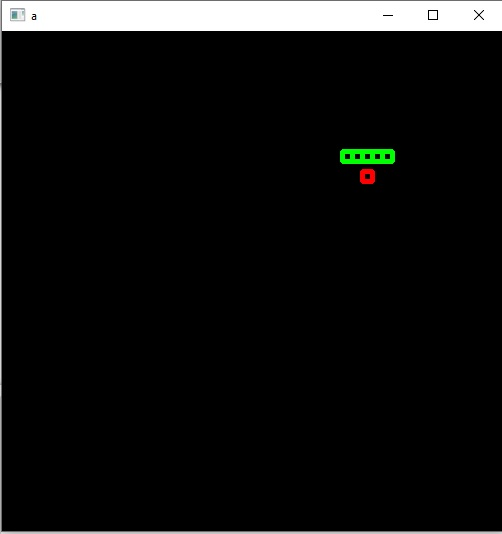

In [22]:
import gym
from gym import spaces
import numpy as np
import cv2
import random
import time
from collections import deque

# The snake game costumized enviroment

In [24]:
def collision_with_apple(apple_position):
    apple_position = [random.randrange(1,50)*10,random.randrange(1,50)*10]
    return apple_position

def collision_with_boundaries(snake_head):
    if snake_head[0]>=500 or snake_head[0]<0 or snake_head[1]>=500 or snake_head[1]<0 :
        return 1
    else:
        return 0

def collision_with_self(snake_position):
    snake_head = snake_position[0]
    if snake_head in snake_position[1:]:
        return 1
    else:
        return 0
    
class SnakeEnv(gym.Env):

    def __init__(self):
        
        super(SnakeEnv, self).__init__()
        
        self.max_snake_length = 10
        self.snake_obs = self.max_snake_length * 2
        self.snake_initial_length = 3
        
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        self.action_space = spaces.Discrete(4)
        # Example for using image as input (channel-first; channel-last also works):
        self.observation_space = spaces.Box(low=-500, high=500, shape=(5+self.snake_obs,), dtype=np.float32)
        # however long we aspire the snake to be
        self.snake_body = deque(maxlen = self.snake_obs) 

    def step(self, action):
        
        # Change the head position based on the button direction
        if action == 1:
            self.snake_head[0] += 10
        elif action == 0:
            self.snake_head[0] -= 10
        elif action == 2:
            self.snake_head[1] += 10
        elif action == 3:
            self.snake_head[1] -= 10

        # Increase Snake length on eating apple
        apple_reward = 0.0
        if self.snake_head == self.apple_position:
            self.apple_position = collision_with_apple(self.apple_position)
            self.snake_position.insert(0,list(self.snake_head))
            apple_reward = 2.0 *(len(self.snake_position)-self.snake_initial_length)
        else:
            self.snake_position.insert(0,list(self.snake_head))
            self.snake_position.pop()
        
        # On collision kill the snake
        if collision_with_boundaries(self.snake_head) == 1 or collision_with_self(self.snake_position) == 1:
            self.done = True
            self.reward = -2.0
        else:
            euclidean_dist_to_apple = np.linalg.norm(np.array(self.snake_head) - np.array(self.apple_position))
            self.total_reward = (self.initial_distance - euclidean_dist_to_apple)/self.initial_distance + \ 
                                apple_reward + 
                                (len(self.snake_position)-self.snake_initial_length)/self.max_snake_length 
            self.reward = self.total_reward - self.prev_total_reward
            self.prev_total_reward = self.total_reward
        
        observation = self._compute_observation()
        
        return observation, self.reward, self.done, {}

    def reset(self):

        # Initial Snake and Apple position
        self.snake_position = [[250,250],[240,250],[230,250]]
        self.apple_position = [random.randrange(1,50)*10,random.randrange(1,50)*10]
        self.snake_head = [250,250]
        self.initial_distance = np.linalg.norm(np.array(self.snake_head) - np.array(self.apple_position)) + 1.0e-6
        
        self.prev_total_reward = 0.0
        
        # empty actions
        for i in range(self.snake_obs):
            self.snake_body.append(-1) 
            
        self.done = False
        observation = self._compute_observation()
        
        return observation
    
    def render(self, mode='human'):
        
        # Create image
        self.img = np.zeros((500,500,3),dtype='uint8')        
        # Display Apple
        cv2.rectangle(self.img,(self.apple_position[0],self.apple_position[1]),(self.apple_position[0]+10,self.apple_position[1]+10),(0,0,255),3)
        
        # Display Snake
        for position in self.snake_position:
            cv2.rectangle(self.img,(position[0],position[1]),(position[0]+10,position[1]+10),(0,255,0),3)
            
        # Display collision text
        if collision_with_boundaries(self.snake_head) == 1 or collision_with_self(self.snake_position) == 1:
            font = cv2.FONT_HERSHEY_SIMPLEX
            self.img = np.zeros((500,500,3),dtype='uint8')
            cv2.putText(self.img,'Snake length {}'.format(len(self.snake_position)),(140,250), font, 1,(255,255,255),2,cv2.LINE_AA)
        
        cv2.imshow('a',self.img)
        cv2.waitKey(10)
    
    def _compute_observation(self):
        head_x = self.snake_head[0]
        head_y = self.snake_head[1]
        
        snake_length = len(self.snake_position)
        apple_delta_x = self.apple_position[0] - head_x
        apple_delta_y = self.apple_position[1] - head_y

        for i in range(1,len(self.snake_position)):
            self.snake_body.append(self.snake_position[i-1][0] -self.snake_position[i][0]) 
            self.snake_body.append(self.snake_position[i-1][1] -self.snake_position[i][1]) 
            

        observation = [head_x, head_y, apple_delta_x, apple_delta_y, snake_length] + list(self.snake_body) 
        observation = np.array(observation)
        
        return observation

SyntaxError: unexpected character after line continuation character (<ipython-input-24-73e032a13e9d>, line 65)

In [25]:
env = SnakeEnv()
episodes = 5

for episode in range(episodes):
    done = False
    obs = env.reset()
    while not done:
        random_action = env.action_space.sample()
        obs, reward, done, info = env.step(random_action)
        #env.render()
        print('reward',reward)

reward -0.065537969306497
reward -2.0
reward -0.03158096241867012
reward -2.0
reward 0.05485838465229894
reward -0.008030234495099056
reward -2.0
reward 0.020573634623832354
reward 0.0644924545737275
reward -0.02199086872301456
reward 0.06245015321260135
reward -0.028010624010654142
reward -2.0
reward -0.057016524497541035
reward -0.059636313520415596
reward 0.0480203985432958
reward -0.06448299908780675
reward -0.04539585415585243
reward -2.0


# Use a stable baselines 3 algorithm to compute the optimal policy

In [26]:
import gym
import os
from stable_baselines3 import PPO

In [27]:
env = SnakeEnv()

In [28]:
model_name = "PPO"
models_dir = "models/" + model_name
logdir = "logs"

In [29]:
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

## Save models at different iterations

In [30]:
env.reset()
if model_name =="PPO":
    model = PPO('MlpPolicy', env, verbose=1, tensorboard_log=logdir)
elif model_name =="A2C":
    model = A2C('MlpPolicy', env, verbose=1, tensorboard_log=logdir)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
TIMESTEPS = 10000
iters = 0
for i in range(20):
    iters += 1
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=model_name)
    model.save(f"{models_dir}/{TIMESTEPS*iters}")

Logging to logs\PPO_0
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 4.44      |
|    ep_rew_mean     | -1.41e+05 |
| time/              |           |
|    fps             | 2164      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.16        |
|    ep_rew_mean          | -2.12       |
| time/                   |             |
|    fps                  | 1515        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014409589 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0           

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 21.5         |
|    ep_rew_mean          | -1.33        |
| time/                   |              |
|    fps                  | 1344         |
|    iterations           | 3            |
|    time_elapsed         | 4            |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0112962965 |
|    clip_fraction        | 0.121        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.699       |
|    explained_variance   | 0.256        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0395       |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.0208      |
|    value_loss           | 0.0825       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 24.9        |
|    ep_rew_mean          | -1.21       |
| time/                   |             |
|    fps                  | 1251        |
|    iterations           | 4           |
|    time_elapsed         | 6           |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.015565265 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.573      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0052      |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.0122     |
|    value_loss           | 3.01e+11    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 26.2  

In [21]:
env.reset()

model_path = f"{models_dir}/160000.zip"

if model_name =="PPO":
    model = PPO.load(model_path, env=env)
elif model_name =="A2C":
    model = A2C.load(model_path, env=env)

episodes = 50
for ep in range(episodes):
    obs = env.reset()
    done = False
    while not done:
        # pass observation to model to get predicted action
        action, _states = model.predict(obs)
        # pass action to env and get info back
        obs, rewards, done, info = env.step(action)
        
        # show the environment on the screen
        env.render()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [11]:
cv2.destroyAllWindows()